In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [46]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import glob
import io
import skimage.io
import skimage.color
import skimage.filters
from tensorflow.python.keras.preprocessing.image import img_to_array,array_to_img
from skimage import data, io, img_as_ubyte
from skimage.filters import threshold_multiotsu
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from PIL import UnidentifiedImageError
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [12]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

In [13]:
DIRECTORY = r"/content/gdrive/MyDrive/SDP/Chinese_Mammogram/"
CATEGORIES = ["Benign", "Malignant"]

data = []
labels = []

In [14]:
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path,target_size=(224,224))
    image = skimage.color.rgb2gray(image)
    blurred_image = skimage.filters.gaussian(image, sigma=1.0)
    t = skimage.filters.threshold_otsu(blurred_image) 
    binary_mask = blurred_image > t
    b_mask = img_to_array(binary_mask)
    image = img_to_array(b_mask)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)

In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [16]:
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [18]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [19]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [21]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/30
107/107 [==============================] - 52s 446ms/step - loss: 0.7429 - accuracy: 0.5505 - val_loss: 0.6444 - val_accuracy: 0.6262
Epoch 2/30
107/107 [==============================] - 44s 408ms/step - loss: 0.6599 - accuracy: 0.6084 - val_loss: 0.6158 - val_accuracy: 0.6998
Epoch 3/30
107/107 [==============================] - 44s 406ms/step - loss: 0.6397 - accuracy: 0.6329 - val_loss: 0.5936 - val_accuracy: 0.6928
Epoch 4/30
107/107 [==============================] - 43s 406ms/step - loss: 0.6223 - accuracy: 0.6557 - val_loss: 0.5782 - val_accuracy: 0.7150
Epoch 5/30
107/107 [==============================] - 43s 406ms/step - loss: 0.6183 - accuracy: 0.6598 - val_loss: 0.5644 - val_accuracy: 0.7371
Epoch 6/30
107/107 [==============================] - 43s 403ms/step - loss: 0.5975 - accuracy: 0.6884 - val_loss: 0.5475 - val_accuracy: 0.7547
Epoch 7/30
107/107 [==============================] - 43s 400ms/step - loss: 0.5987 - accuracy: 0.6779 - v

[INFO] evaluating network...
              precision    recall  f1-score   support

      Benign       0.79      0.89      0.84       387
   Malignant       0.90      0.81      0.85       469

    accuracy                           0.85       856
   macro avg       0.85      0.85      0.85       856
weighted avg       0.85      0.85      0.85       856

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


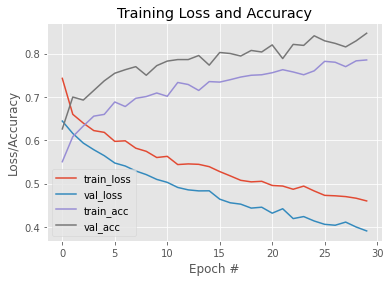

In [23]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
pred = predIdxs 

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
# model.save("malignancy_detector.h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [26]:
matrix = confusion_matrix(testY.argmax(axis=1), predIdxs)
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(testY.argmax(axis=1), predIdxs).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(testY.argmax(axis=1), predIdxs)
print('Classification report : \n',matrix)

Confusion matrix : 
 [[346  41]
 [ 90 379]]
Outcome values : 
 346 41 90 379
Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       387
           1       0.90      0.81      0.85       469

    accuracy                           0.85       856
   macro avg       0.85      0.85      0.85       856
weighted avg       0.85      0.85      0.85       856



In [29]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float32'))
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure


[[346  41]
 [ 90 379]]


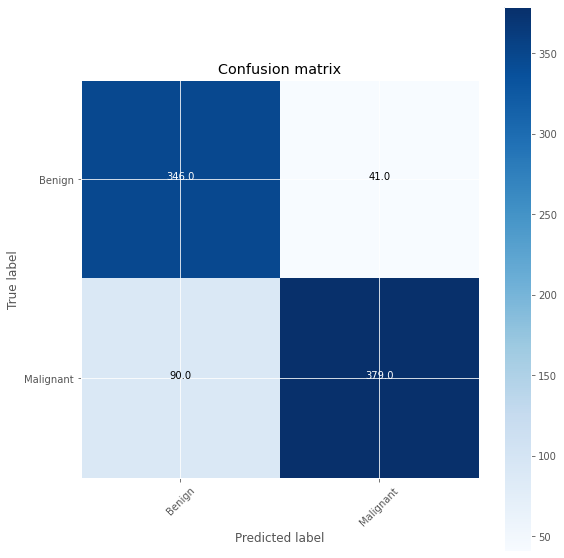

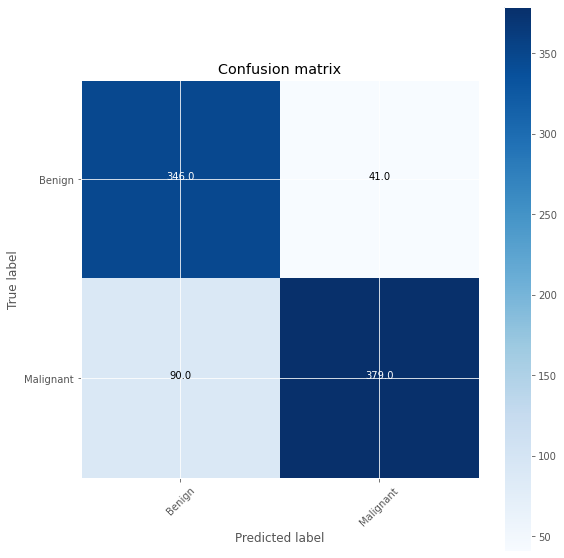

In [30]:
cm=confusion_matrix(testY.argmax(axis=1), predIdxs)
print(cm)
plot_confusion_matrix(cm,lb.classes_)

In [31]:
auc = roc_auc_score(testY.argmax(axis=1), predIdxs)
print('AUC: %.3f' % auc)

AUC: 0.851


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

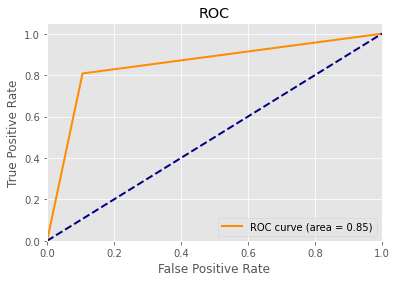

In [33]:
# roc curve and auc
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
fpr, tpr, _ = roc_curve(testY.argmax(axis=1), predIdxs)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [35]:
from tensorflow.keras.models import load_model

model.save('model_malignancy.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('model_malignancy.h5')

In [43]:
def predict_Severity(filename):
    img1 = image.load_img(filename,target_size=(224,224))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("Malignant",fontsize=30)
        
    
    elif val == 0:
        
        plt.xlabel("Benign",fontsize=30)

[[0.]]


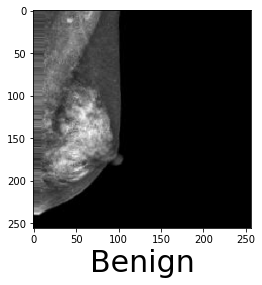

In [ ]:
predict_Severity(r"/content/gdrive/MyDrive/SDP/CM/Test/Benign/B_0_1028.jpeg")

[[0.]]


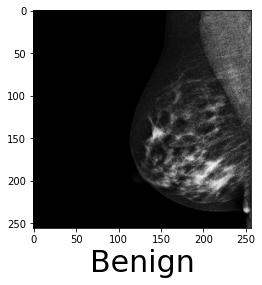

In [ ]:
predict_Severity(r"/content/gdrive/MyDrive/SDP/CM/Test/Benign/72 - Copy (2).jpeg")

In [3]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("/content/gdrive/MyDrive/SDP/CM/Train/",
                                          target_size=(256,256),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("/content/gdrive/MyDrive/SDP/CM/Test/",
                                          target_size=(256,256),
                                          batch_size =32,
                                          class_mode = 'binary')

print(test_dataset.class_indices)

Found 8086 images belonging to 2 classes.
Found 3016 images belonging to 2 classes.
{'Benign': 0, 'Malignant': 1}


In [5]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for Cat or 1 for Dog 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#steps_per_epoch = train_imagesize/batch_size

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [7]:
r=model.fit(train_dataset,
         steps_per_epoch = 250,
         epochs = 10,
         validation_data = test_dataset
       
         )

Epoch 1/10
250/250 [==============================] - 1601s 6s/step - loss: 0.6458 - accuracy: 0.6020 - val_loss: 0.5759 - val_accuracy: 0.6950
Epoch 2/10
250/250 [==============================] - 72s 290ms/step - loss: 0.4522 - accuracy: 0.7780 - val_loss: 0.5124 - val_accuracy: 0.7454
Epoch 3/10
250/250 [==============================] - 64s 257ms/step - loss: 0.2297 - accuracy: 0.9060 - val_loss: 0.5604 - val_accuracy: 0.7997
Epoch 4/10
250/250 [==============================] - 65s 258ms/step - loss: 0.0947 - accuracy: 0.9646 - val_loss: 0.7595 - val_accuracy: 0.8050
Epoch 5/10
250/250 [==============================] - 64s 257ms/step - loss: 0.0351 - accuracy: 0.9882 - val_loss: 0.9801 - val_accuracy: 0.8243
Epoch 6/10
250/250 [==============================] - 64s 256ms/step - loss: 0.0287 - accuracy: 0.9914 - val_loss: 0.9438 - val_accuracy: 0.8316
Epoch 7/10
250/250 [==============================] - 64s 258ms/step - loss: 0.0112 - accuracy: 0.9976 - val_loss: 0.9277 - val_acc